# Exploring Player Data on Stratus - A Web Scraping and EDA Project
---
- **Made by:** *Philip Sinnott*
- **GitHub:** [@philipsinnott](https://github.com/philipsinnott)
- **Blog:** [sinnott.netlify.app](https://sinnott.netlify.app)

# NOTE
To see the full walkthrough and discussion/analysis of the code and plots below, see my [blog post](https://sinnott.netlify.app/docs/exploring-player-data-on-stratus-a-web-scraping-and-eda-project/). This notebook is not very structured right now, and serves more as a place to see all of the code used in the project.

## 3.1 Acquire data
---

In [52]:
# Imports
from bs4 import BeautifulSoup
import requests
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from scipy import stats
import json
import re
from itertools import chain
from concurrent.futures import ThreadPoolExecutor
import threading
import itertools
import urllib.request
from PIL import Image

In [53]:
def get_data_as_soup(url):
    data = requests.get(url).text
    soup = BeautifulSoup(data, "html.parser")
    return soup

In [54]:
url = "https://stratus.network/leaderboard/stratus14,*,*,*/wins/1"
soup = get_data_as_soup(url)
#soup

In [55]:
def scrape_lb_data(soup):
    # Get name of each column header
    t_head = soup.find_all("tr", "MuiTableRow-root MuiTableRow-head")

    # Append each column header to a list
    column_headers = []
    for i in t_head:
        for j in i.find_all("th"):
            column_headers.append(j.text)
    
    # Get data from top table body containing top 100 players
    t_body = soup.find_all("tr", class_="MuiTableRow-root")
    rank_rows = soup.find_all("tr", class_="MuiTableRow-root")
    players_data = []
    current_player = []
    # Loop through each row on leaderboard
    for i, rank_row in zip(t_body, rank_rows):
        rank = rank_row.find("td", class_="MuiTableCell-root MuiTableCell-body jss41 MuiTableCell-alignRight")
        if rank:
            current_player.append(rank.text)
        for j in i.find_all("span"):
            data = j.text.strip()
            #print(data)
            current_player.append(data)
        # If list containing player data isn't empty --> append to list containing all player data
        if current_player:
            players_data.append(current_player)
        # Reset list for next player
        current_player = []
    # Append last player on leaderboard to list containing all player data
    if current_player:
        players_data.append(current_player)
    # Return 2D list where each player corresponds to one sublist, along with the column headers
    return [players_data, column_headers]

In [56]:
players_data = scrape_lb_data(soup)[0] # body data
column_headers = scrape_lb_data(soup)[1] # header
#players_data

## 3.2 Data Conversion & Preprocessing
---

In [57]:
def clean_lb_data(data, cols):   
    # Creating the df
    df = pd.DataFrame(data, columns=cols)
    # Rename ranking col
    df.rename(columns={"#":"Ranking"}, inplace=True)
    
    # Remove unwanted chars from data so we eventually can store all vars in numeric form
    df["Kills per Game"] = df["Kills per Game"].str.removesuffix("/game")
    df["Damage Dealt per Minute"] = df["Damage Dealt per Minute"].str.removesuffix("\u2006/min")
    df["Ranking"] = df["Ranking"].str.replace("#", "")
    df["Bow Accuracy"] = df["Bow Accuracy"].str.replace("%", "")

    # Remove commas
    for col in df.columns:
        df[col] = df[col].str.replace(",", "")

    # Transform all cols except for Player from obj --> numerical dtype
    for col in df.columns[[0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13]]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Store bow accuracy metric in float instead of percentage
    df["Bow Accuracy"] = df["Bow Accuracy"].apply(lambda x: x / 100)

    # Show values in full length, e.g. "1.5M" --> "1500000" and "500k" --> "500000"
    # also converts values to ints
    df["Damage Dealt"] = df["Damage Dealt"].apply(lambda x: pd.to_numeric(x.replace('M',''))*1000000 if 'M' in x
                                                      else pd.to_numeric(x.replace('k',''))*1000 if 'k' in x
                                                          else pd.to_numeric(x))
    df["Damage Dealt"] = df["Damage Dealt"].astype(int)
    
    return df

In [58]:
df_lb = clean_lb_data(players_data, column_headers)

# Print info and make sure all columns except for "Player" are numeric dt
#print(df_lb.info())
#df_lb

## 3.3 Complementing the Leaderboards Dataset with Player Profile Data
---

In [59]:
base_url = "https://stratus.network/"

def scrape_player_profile_data(season, df):
    players = df["Player"].to_list() # get all player names from lb list
    # i keep getting errors when player "sqyid" is in list, so i removed him
    if any(x == "sqyid" for x in players):
        players.remove("sqyid")
    
    threads = []
    players_data = []
    # iterates over all players
    for player in players:
        # creates a new thread for each player
        thread = threading.Thread(target=process_player, args=(player, season, players_data))
        thread.start()
        threads.append(thread)
    # wait until all threads have finished processing
    for thread in threads:
        thread.join()
        
    return players_data

def process_player(player, season, players_data):
    url = f"{base_url}{player}" # craft url for player
    data = requests.get(url).text # get html in raw text format
    data = BeautifulSoup(data, "html.parser") # create soup object
    
    # filter data to where relevant stats start
    data = data.find('script', text=lambda t: t.startswith('window.initialReactProps='))
    # remove script tags
    data = json.loads(data.text.split("=")[1][:-1])
    # convert string to dictionary
    data = json.loads(data)
    # specify what json object we're looking for
    data = data["props"]["ranked"]
    # use dict comprehension to add key-value pair containing name/ign of player
    data = [{'Name': player, **d} for d in data]
    # search for specific season and show stats from that season
    player_data = list(filter(lambda x: x["season"] == (f"{season}"), data))
    # append individual player data to main list
    players_data.append(player_data)

In [60]:
df_profile = scrape_player_profile_data(15, df_lb)
#df_profile

### 3.3.1 Data Conversion & Preprocessing

In [61]:
# Flatten list of lists and convert to df
def process_player_profile_data(data):
    # flatten 2D list --> 1D list
    flat_data = list(chain.from_iterable(data))
    # convert to df
    df_player_profile = pd.DataFrame.from_records(flat_data)
    # rename name/ign col to suit lb dataset
    df_player_profile.rename(columns={"Name":"Player"}, inplace=True)
    return df_player_profile

In [62]:
df_profile = process_player_profile_data(df_profile)
#df_profile.describe() # show metrics
#df_profile

### 3.3.2 Merge Datasets

In [63]:
# Merge extended df with already existing df
# and do some basic processing
def merge_lb_and_player_profile_data(df1, df2):
    # merge dfs
    df_merged = pd.merge(df1, df2, on='Player')
    # add w/l column
    df_merged = df_merged.assign(w_l=df_merged['Wins'] / df_merged['losses'])
    # convert season column from obj to int
    df_merged['season'] = df_merged['season'].astype(int)
    return df_merged

# drop irrelevant cols
def drop_cols(df, cols, axis):
    df = df.drop(columns=cols, axis=axis)
    return df

In [64]:
df_merged = merge_lb_and_player_profile_data(df_lb, df_profile)
df = drop_cols(df_merged, cols=["discord", "season", "baseSeason", "discordName", "name", "wellFormed", "rank", "kills", "deaths"], axis=1)
#df

In [65]:
# Create non_prem df for all columns except for those related to premium queue
def create_non_prem_df(df, cols, axis):
    df_non_prem = df.drop(columns=cols, axis=axis)
    return df_non_prem

In [66]:
df_non_prem = df.drop(columns=["premium_games", "premium_wins", "premium_losses", "premium_kills", "premium_deaths"], axis=1)
#df_non_prem.columns

In [67]:
def create_df(season):
    # set base url for lb data
    base_url_lb = "https://stratus.network/leaderboard/"
    # get lb data
    lb_data = get_data_as_soup(f"{base_url_lb}stratus{season},*,*,*/wins/1")
    players_data = scrape_lb_data(lb_data)[0]
    column_headers = scrape_lb_data(lb_data)[1]
    lb_data = clean_lb_data(players_data, column_headers)
    
    # get player profile data
    player_profile_data = scrape_player_profile_data(season, lb_data)
    # process player profile data
    player_profile_data = process_player_profile_data(player_profile_data)
    # merge lb data and player profile data
    df_merged = merge_lb_and_player_profile_data(lb_data, player_profile_data)
    # drop unneeded columns
    df = drop_cols(df_merged, cols=["discord", "baseSeason", "discordName", "name", "wellFormed", "rank", "kills", "deaths"], axis=1)
    # create separate df with premium queue columns excluded
    df_non_prem = create_non_prem_df(df, cols=["premium_games", "premium_wins", "premium_losses", "premium_kills", "premium_deaths"], axis=1)
    return [df, df_non_prem]

In [68]:
# Create multiple dfs for specified seasons
def create_multiple_dfs(seasons):
    dfs = []
    dfs_non_prem = []
    for season in seasons:
        df_season, df_non_prem_season = create_df(season)
        dfs.append(df_season)
        dfs.append(df_non_prem_season)
        dfs_non_prem.append(df_non_prem_season)
    return [dfs, dfs_non_prem]

[dfs, dfs_non_prem] = create_multiple_dfs([13, 14, 15])

In [69]:
# Split seasons into separate dfs
s13 = dfs[0]
s13_non_prem = dfs[1]

s14 = dfs[2]
s14_non_prem = dfs[3]

s15 = dfs[4]
s15_non_prem = dfs[5]

# 4. Exploratory Data Analysis (EDA)
---

### 4.1.1 Season 13

In [70]:
print(f"Season 13: {s13.info()}\n{s13.describe()})")
print(f"[Null values]:\n{s13.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  100 non-null    int64  
 1   Player                   100 non-null    object 
 2   Wins                     100 non-null    int64  
 3   Kills                    100 non-null    int64  
 4   Deaths                   100 non-null    int64  
 5   KDR                      100 non-null    float64
 6   Damage Dealt             100 non-null    int32  
 7   Kills per Game           100 non-null    float64
 8   Damage Dealt per Minute  100 non-null    float64
 9   Melee/Bow Damage Ratio   100 non-null    float64
 10  Bow Accuracy             100 non-null    float64
 11  Flags                    100 non-null    int64  
 12  Golden Apples Eaten      100 non-null    int64  
 13  Rating                   100 non-null    float64
 14  best_elo                 10

### 4.1.2 Season 14

In [71]:
print(f"Season 14: {s14.info()}\n{s14.describe()}")
print(f"[Null values]:\n{s14.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  100 non-null    int64  
 1   Player                   100 non-null    object 
 2   Wins                     100 non-null    int64  
 3   Kills                    100 non-null    int64  
 4   Deaths                   100 non-null    int64  
 5   KDR                      100 non-null    float64
 6   Damage Dealt             100 non-null    int32  
 7   Kills per Game           100 non-null    float64
 8   Damage Dealt per Minute  100 non-null    float64
 9   Melee/Bow Damage Ratio   100 non-null    float64
 10  Bow Accuracy             100 non-null    float64
 11  Flags                    100 non-null    int64  
 12  Golden Apples Eaten      100 non-null    int64  
 13  Rating                   100 non-null    float64
 14  best_elo                 10

### 4.1.3 Season 15

In [72]:
print(f"Season 15: {s15.info()}\n{s15.describe()}")
print(f"[Null values]:\n{s15.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  99 non-null     int64  
 1   Player                   99 non-null     object 
 2   Wins                     99 non-null     int64  
 3   Kills                    99 non-null     int64  
 4   Deaths                   99 non-null     int64  
 5   KDR                      99 non-null     float64
 6   Damage Dealt             99 non-null     int32  
 7   Kills per Game           99 non-null     float64
 8   Damage Dealt per Minute  99 non-null     float64
 9   Melee/Bow Damage Ratio   99 non-null     float64
 10  Bow Accuracy             99 non-null     float64
 11  Flags                    99 non-null     int64  
 12  Golden Apples Eaten      99 non-null     int64  
 13  Rating                   99 non-null     float64
 14  best_elo                 99 

## 4.2 Analyzing the Factors that Affect Win-Loss Ratio
---

### 4.2.1 Correlation matrix
---

#### 4.2.1.1 Season 13

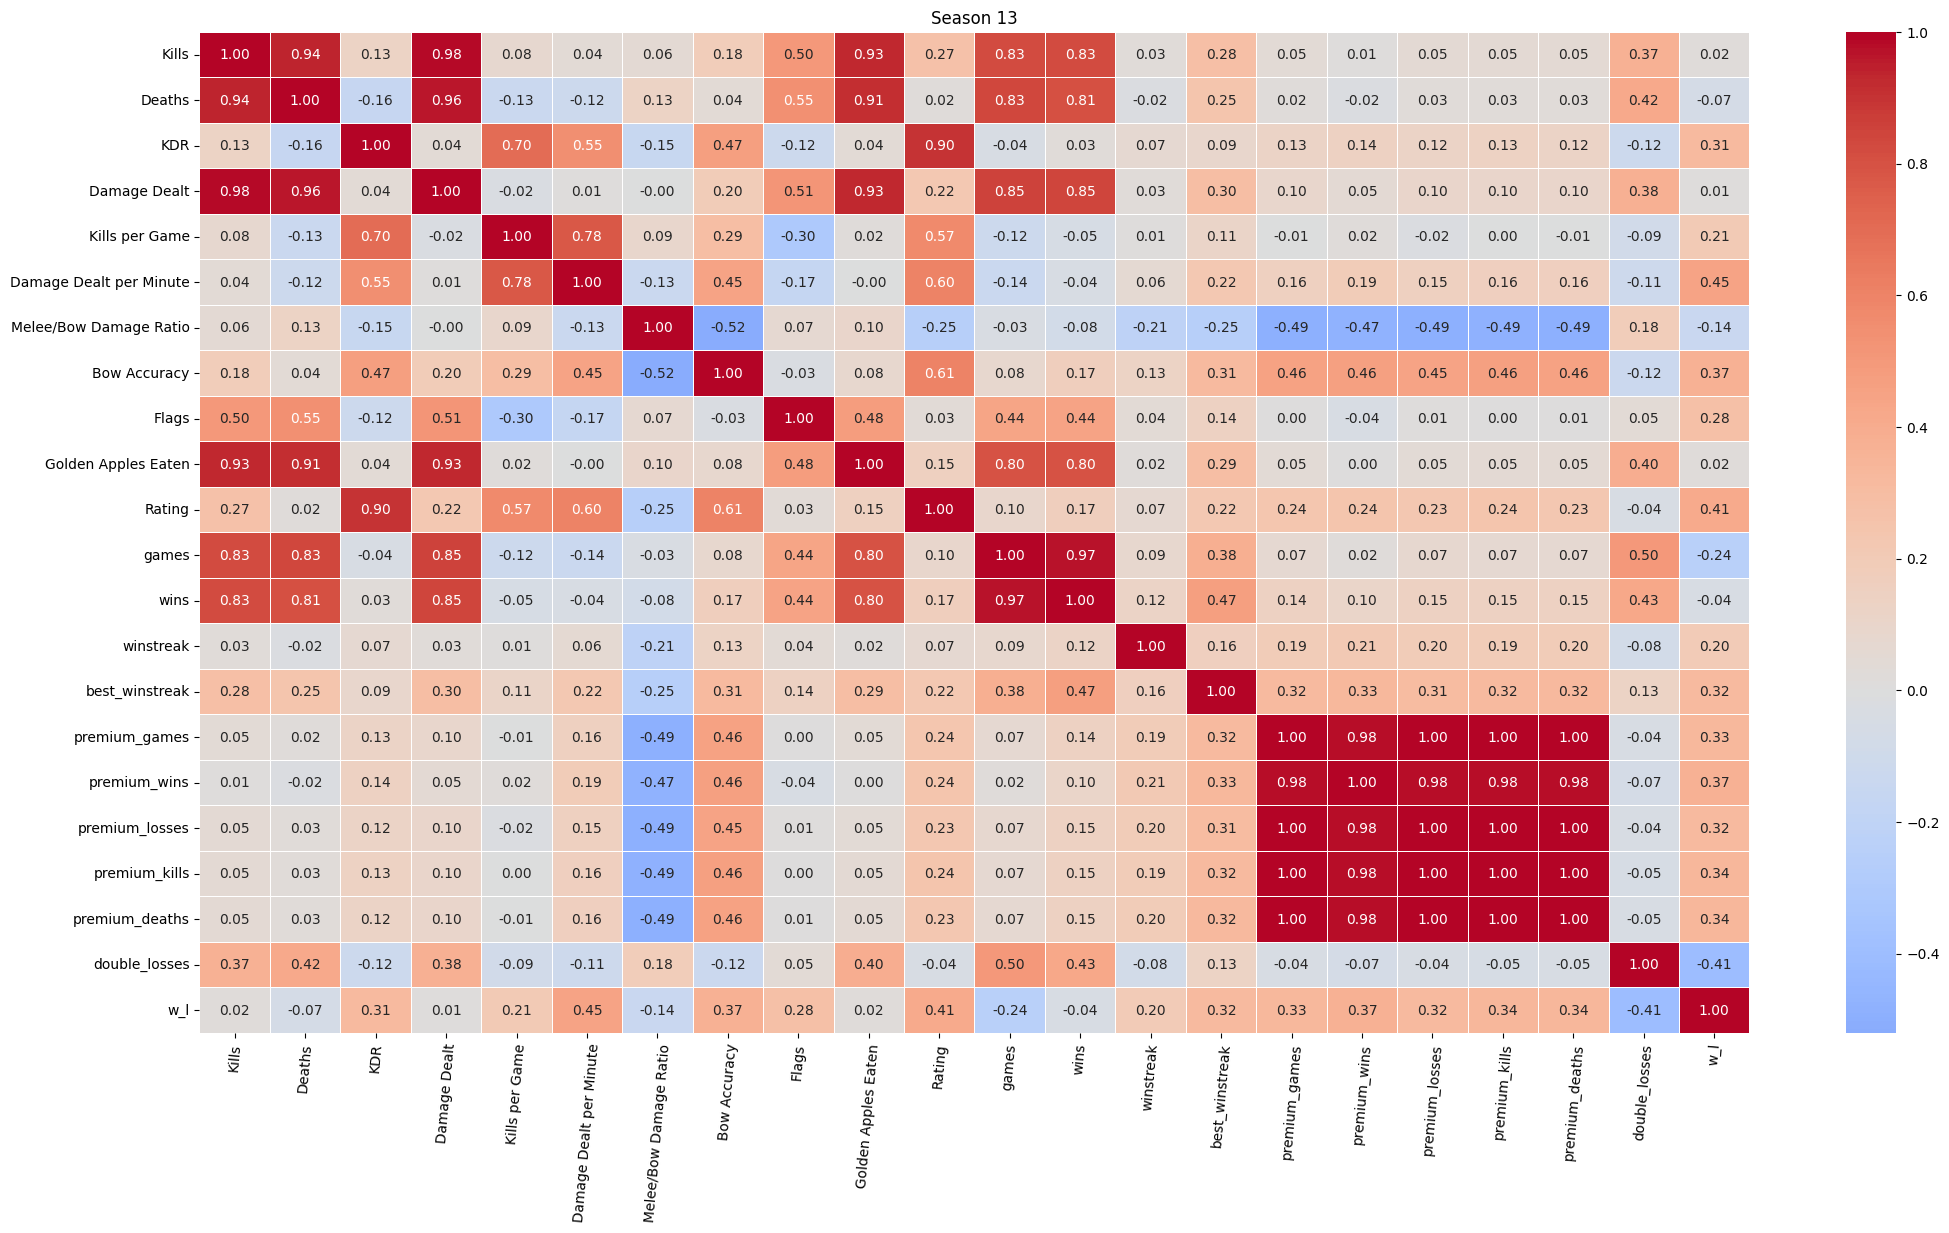

In [136]:
corr = s13.drop(['season', 'Wins', 'losses', 'Ranking', 'best_elo', 'elo'], axis=1).corr(method='spearman', numeric_only=True)

plt.figure(figsize=(25,13))
plt.title("Season 13")
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5, linecolor='white')
xticks = plt.gca().get_xticklabels()
res = plt.setp(xticks, rotation=85)

In [132]:
# identify outliers
print(s13["double_losses"].describe(),"\n")

# filter df to  only show players with 5 or more double_losses
filtered_df = s13[s13['double_losses'] >= 5]
# sort in descending order
filtered_df = filtered_df.sort_values("double_losses", ascending=False)
print(filtered_df[["Player", "double_losses"]])

count    100.000000
mean       2.320000
std        3.923202
min       -1.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       21.000000
Name: double_losses, dtype: float64 

              Player  double_losses
7      legrandmystic             21
13            sil4nt             17
20            Vaiuuu             15
39      AlexHitchens             15
0         Inductions             14
6            Algerie             13
30              grq_              8
76             Wakhi              8
97           Kardesh              8
31  BenjaminFlanking              7
22           HordyXD              5


#### 4.2.1.2 Season 14

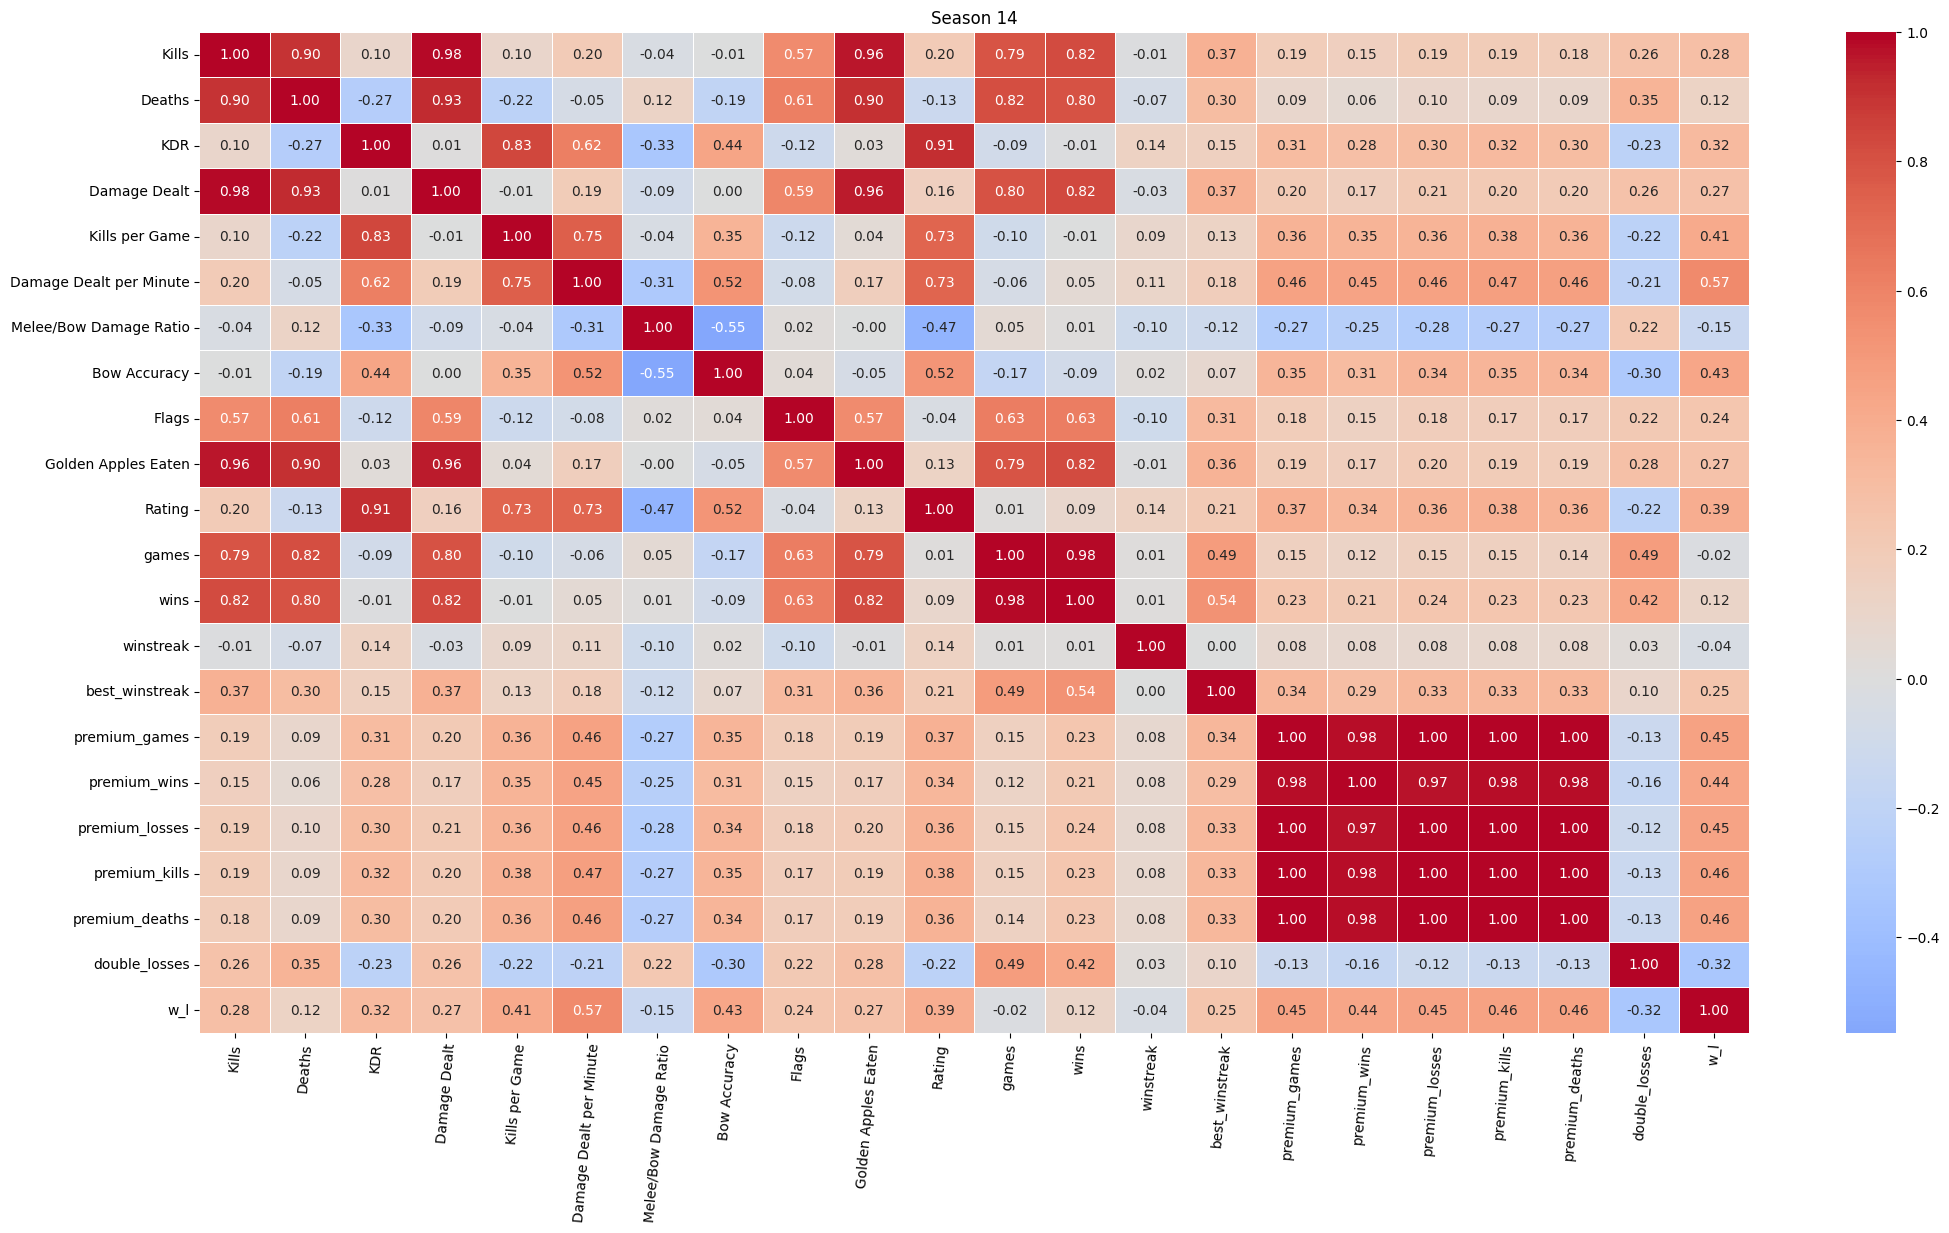

In [135]:
corr = s14.drop(['season', 'Wins', 'losses', 'Ranking', 'best_elo', 'elo'], axis=1).corr(method='spearman', numeric_only=True)

plt.figure(figsize=(25,13))
plt.title("Season 14")
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5, linecolor='white')
xticks = plt.gca().get_xticklabels()
res = plt.setp(xticks, rotation=85)

In [144]:
# identify outliers
print(s14["Melee/Bow Damage Ratio"].describe(),"\n")

# filter df
filtered_df_s14 = s14[s14['Melee/Bow Damage Ratio'] >= 4]
# sort in descending order
filtered_df_s14 = filtered_df_s14.sort_values("Melee/Bow Damage Ratio", ascending=False)
print(filtered_df_s14[["Player", "Melee/Bow Damage Ratio"]])

count    100.000000
mean       2.943900
std        1.474319
min        1.510000
25%        2.405000
50%        2.650000
75%        3.147500
max       15.710000
Name: Melee/Bow Damage Ratio, dtype: float64 

             Player  Melee/Bow Damage Ratio
61  AhmetYilzdizPvP                   15.71
22         PlayHigh                    4.77
11    legrandmystic                    4.73
40        abellllll                    4.72
68            smere                    4.46
84         Brokksyn                    4.32
53           jofa56                    4.29
98          Skyxzzz                    4.23
80    deprxssivikno                    4.19
46            zReia                    4.12
95            Dukih                    4.09


#### 4.2.1.3 Season 15 (ongoing)

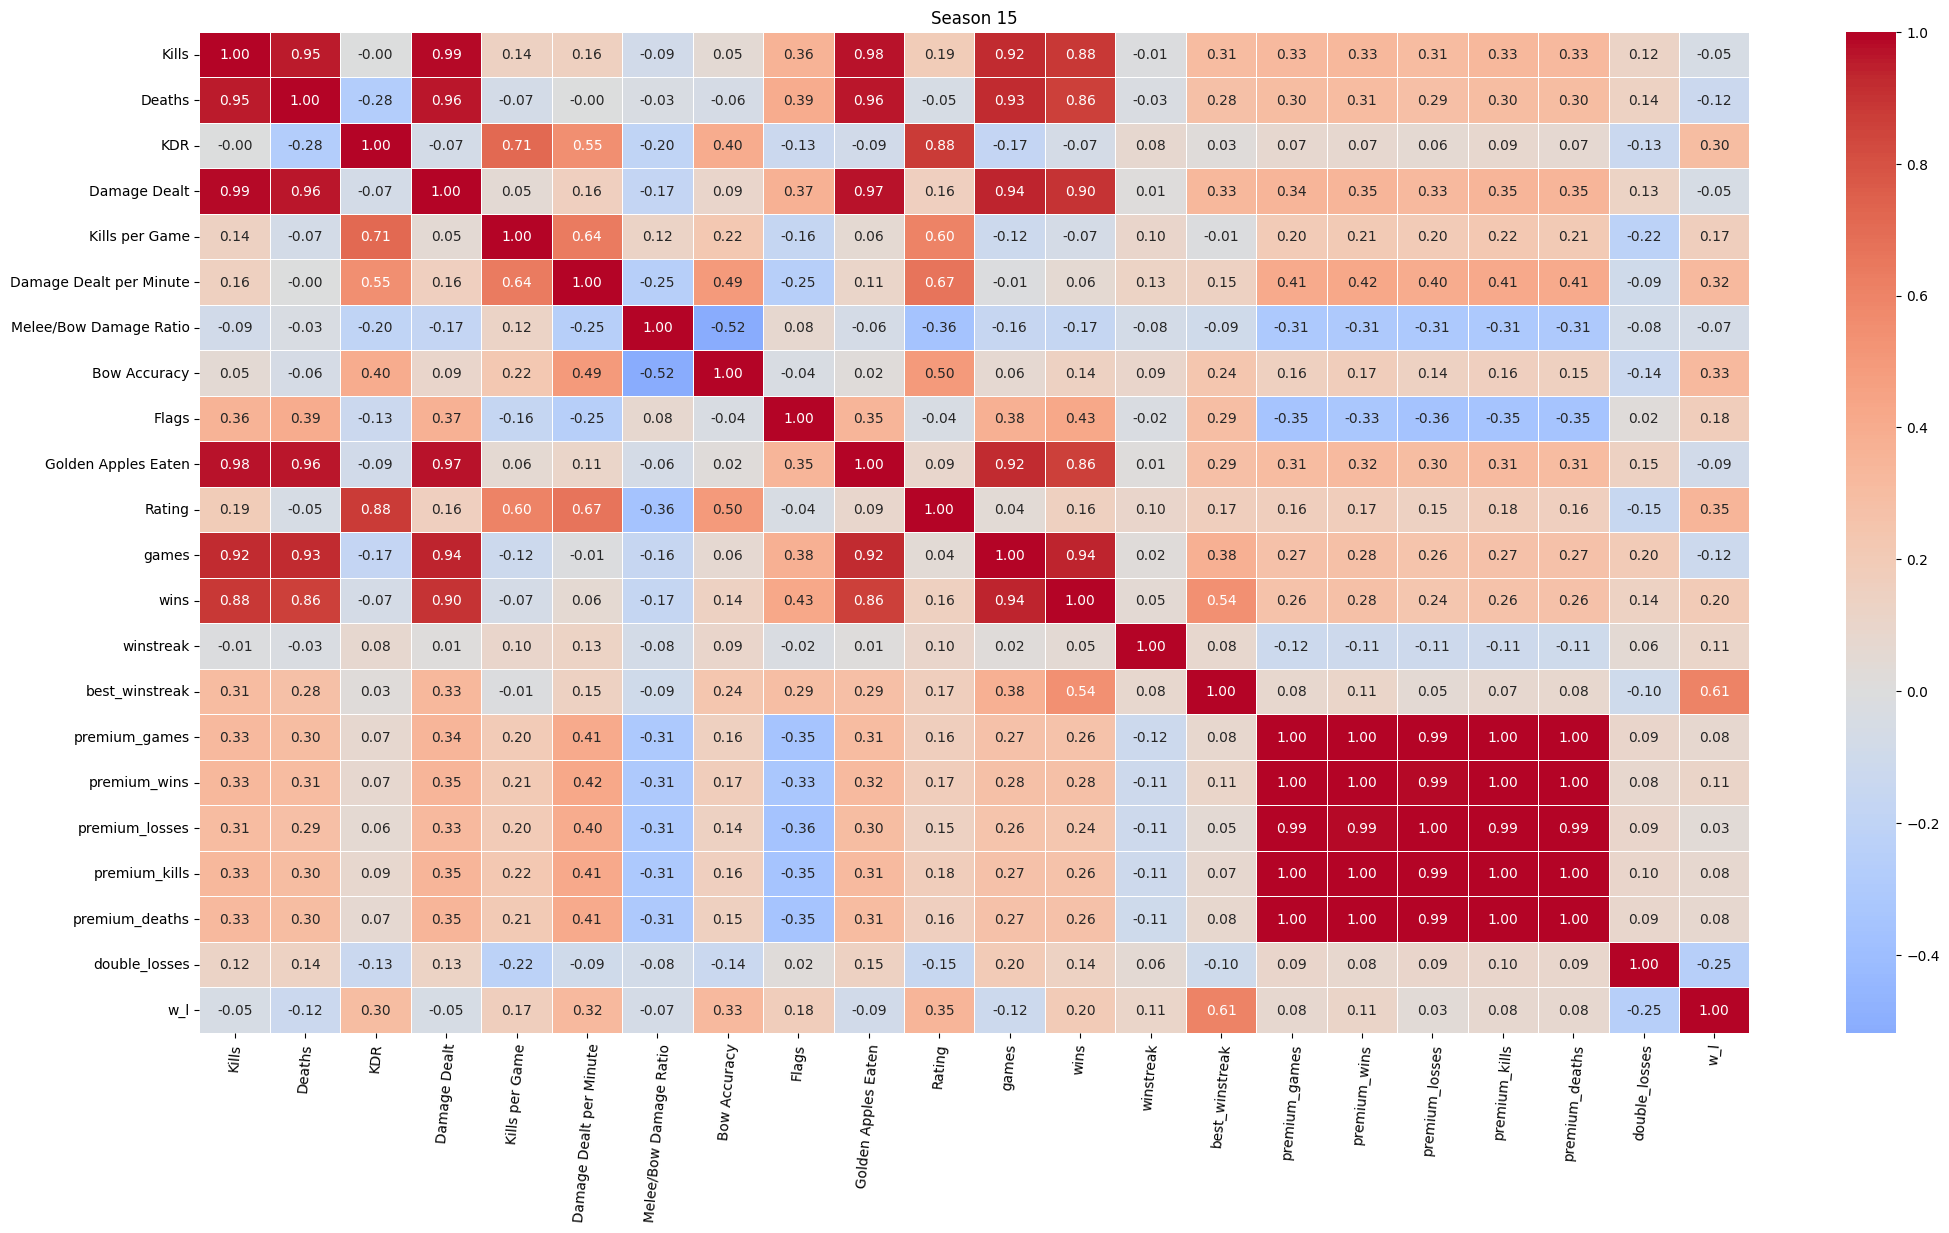

In [145]:
corr = s15.drop(['season', 'Wins', 'losses', 'Ranking', 'best_elo', 'elo'], axis=1).corr(method='spearman', numeric_only=True)

plt.figure(figsize=(25,13))
plt.title("Season 15")
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5, linecolor='white')
xticks = plt.gca().get_xticklabels()
res = plt.setp(xticks, rotation=85)

### 4.2.2 Scatter Matrices
---

#### Create custom colorbar

In [146]:
# Create custom cbar for rank colors (bronze/silver/gold/emerald/diamond/plasma)
import matplotlib.colors as mcolors

# Define colors
colors = [(111/255, 50/255, 42/255), (107/255, 110/255, 121/255), (255/255, 173/255, 0/255), (24/255, 200/255, 82/255), (0/255, 237/255, 252/255), (44/255, 20/255, 69/255)]

# Define value ranges
vals = [0, 200, 400, 600, 800, 1000, 1300]

# Create the colormap
cmap = mcolors.ListedColormap(colors, name='custom')

# Create the norm
norm = mcolors.BoundaryNorm(vals, cmap.N)

#### 4.2.2.1 Kills per Game
---

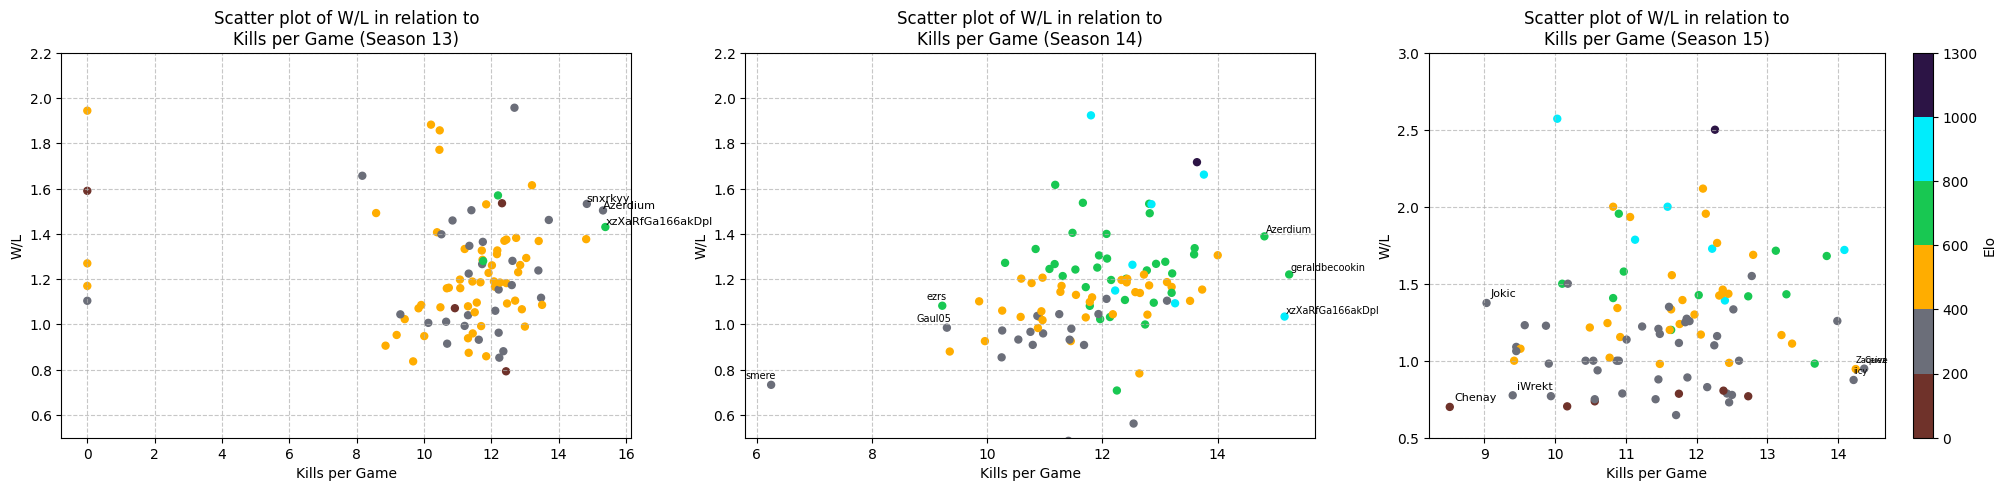

In [194]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

# Find the top 3 outliers (top/low) for Rating in s13 DataFrame
top_outliers = s13.nlargest(3, 'Kills per Game')
#banned players
#low_outliers = s13.nsmallest(3, 'Kills per Game')

# Plot the scatter plot
sc = axs[0].scatter(x=s13['Kills per Game'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Kills per Game')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nKills per Game (Season 13)')
axs[0].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[0], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=8)

#for i, player in low_outliers.iterrows():
#    axs[0].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(-15,5), textcoords='offset points', ha='left', va='bottom', fontsize=10)

# Find the top 3 outliers (top/low) for Kills per Game in s14 DataFrame
top_outliers = s14.nlargest(3, 'Kills per Game')
low_outliers = s14.nsmallest(3, 'Kills per Game')

# Plot the scatter plot
sc = axs[1].scatter(x=s14['Kills per Game'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Kills per Game')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nKills per Game (Season 14)')
axs[1].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[1], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(3,3), textcoords='offset points', ha='right', va='bottom', fontsize=7)


# Find the top 3 outliers (top/low) for Kills per Game in s15 DataFrame
top_outliers = s15.nlargest(3, 'Kills per Game')
low_outliers = s15.nsmallest(3, 'Kills per Game')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Kills per Game'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Kills per Game')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nKills per Game (Season 15)')
axs[2].grid(True, linestyle='--', alpha=0.7)
fig.colorbar(sc, ax=axs[2], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(0,3), textcoords='offset points', ha='left', va='bottom', fontsize=6)

for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Kills per Game'], player["w_l"]), xytext=(3,3), textcoords='offset points', ha='left', va='bottom', fontsize=8)

plt.show()

#### 4.2.2.2  Damage Dealt per Minute
---

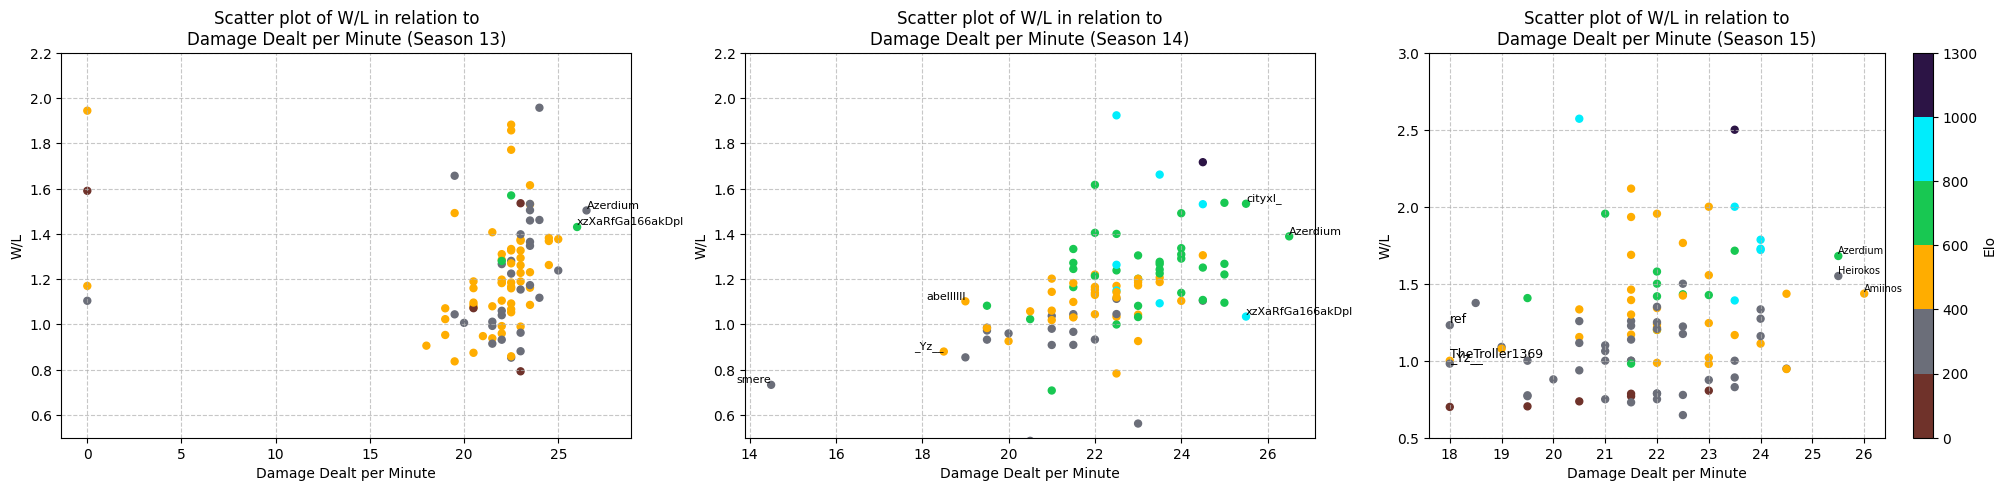

In [195]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

# Find the top 3 outliers (top/low) for Damage Dealt per Minute in s13 DataFrame
top_outliers = s13.nlargest(3, 'Damage Dealt per Minute')
# all banned players
#low_outliers = s13.nsmallest(3, 'Damage Dealt per Minute')

#Plot the scatter plot
sc = axs[0].scatter(x=s13['Damage Dealt per Minute'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Damage Dealt per Minute')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nDamage Dealt per Minute (Season 13)')
axs[0].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[0], label="Elo")

#Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=8)

#for i, player in low_outliers.iterrows():
#    axs[0].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(-15,5), textcoords='offset points', ha='left', va='bottom', fontsize=10)

# Find the top 3 outliers (top/low) for Damage Dealt per Minute in s14 DataFrame
top_outliers = s14.nlargest(3, 'Damage Dealt per Minute')
low_outliers = s14.nsmallest(3, 'Damage Dealt per Minute')

#Plot the scatter plot
sc = axs[1].scatter(x=s14['Damage Dealt per Minute'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Damage Dealt per Minute')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nDamage Dealt per Minute (Season 14)')
axs[1].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[1], label="Elo")

#Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=8)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='right', va='bottom', fontsize=8)

#Find the top 3 outliers (top/low) for Damage Dealt per Minute in s15 DataFrame
top_outliers = s15.nlargest(3, 'Damage Dealt per Minute')
low_outliers = s15.nsmallest(3, 'Damage Dealt per Minute')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Damage Dealt per Minute'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Damage Dealt per Minute')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nDamage Dealt per Minute (Season 15)')
axs[2].grid(True, linestyle='--', alpha=0.7)
fig.colorbar(sc, ax=axs[2], label="Elo")

#Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)
for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Damage Dealt per Minute'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=9)
    
plt.show()

#### 4.2.2.3 Rating
---

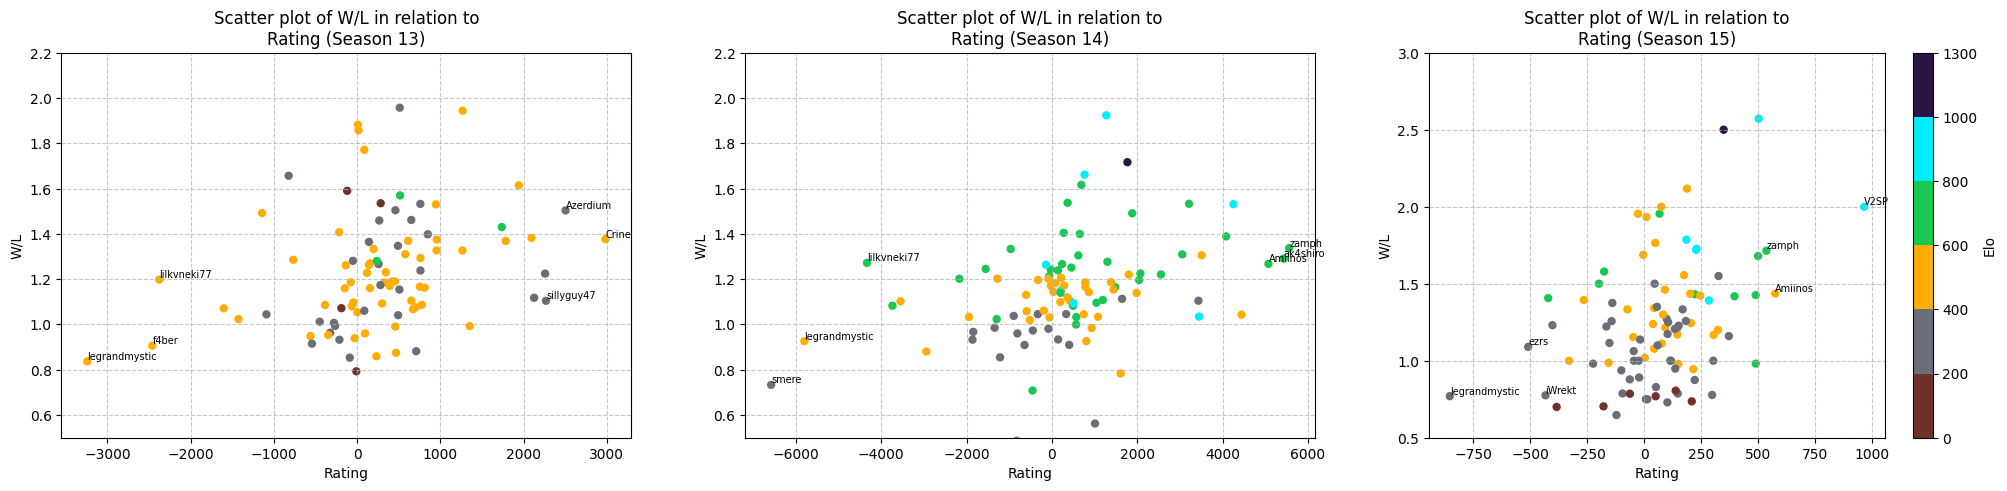

In [196]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

# Find the top 3 outliers (top/low) for Rating in s13 DataFrame
top_outliers = s13.nlargest(3, 'Rating')
low_outliers = s13.nsmallest(3, 'Rating')

# Plot the scatter plot
sc = axs[0].scatter(x=s13['Rating'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nRating (Season 13)')
axs[0].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[0], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

# Find the top 3 outliers (top/low) for Rating in s14 DataFrame
top_outliers = s14.nlargest(3, 'Rating')
low_outliers = s14.nsmallest(3, 'Rating')

# Plot the scatter plot
sc = axs[1].scatter(x=s14['Rating'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nRating (Season 14)')
axs[1].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[1], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)


# Find the top 3 outliers (top/low) for Rating in s15 DataFrame
top_outliers = s15.nlargest(3, 'Rating')
low_outliers = s15.nsmallest(3, 'Rating')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Rating'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Rating')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nRating (Season 15)')
axs[2].grid(True, linestyle='--', alpha=0.7)
fig.colorbar(sc, ax=axs[2], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Rating'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

plt.show()

#### 4.2.2.4 Bow Accuracy
---

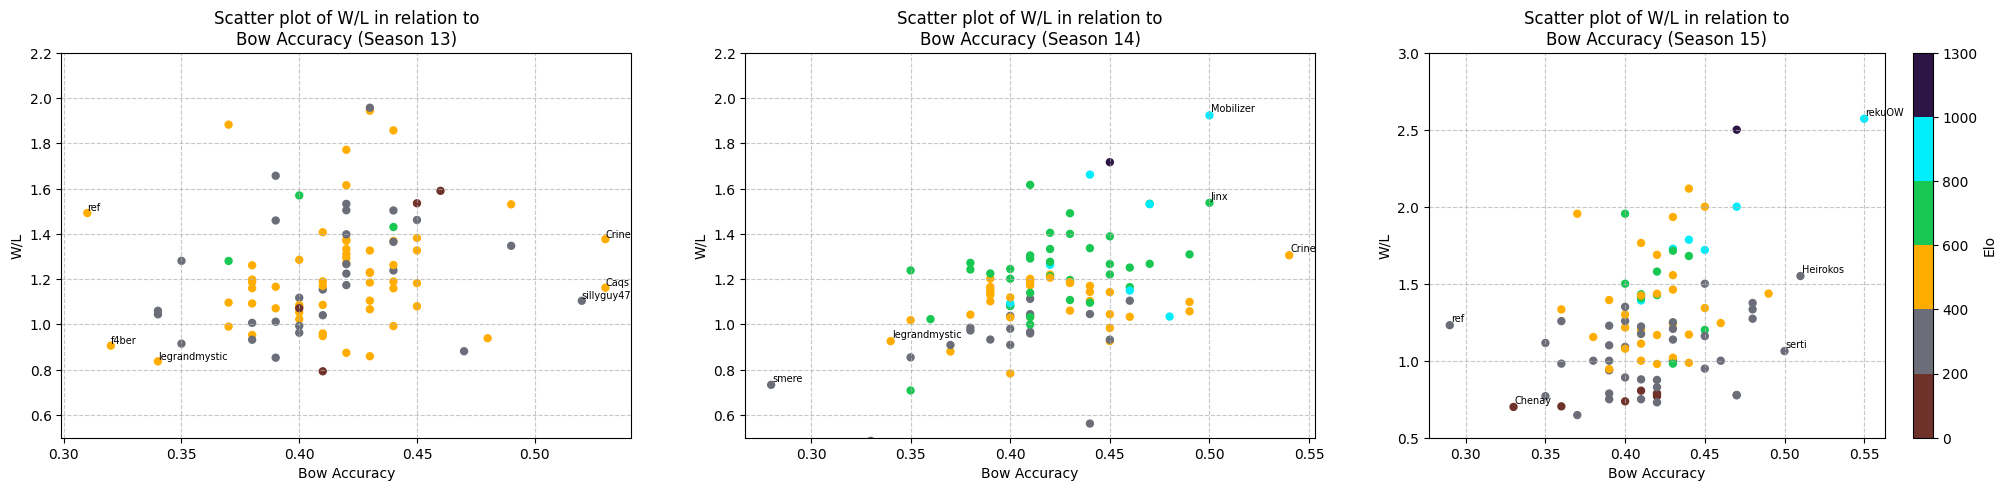

In [197]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

# Find the top 3 outliers (top/low) for Bow Accuracy in s13 DataFrame
top_outliers = s13.nlargest(3, 'Bow Accuracy')
low_outliers = s13.nsmallest(3, 'Bow Accuracy')

# Plot the scatter plot
sc = axs[0].scatter(x=s13['Bow Accuracy'], y=s13["w_l"], marker='o', c=s13['elo'], cmap=cmap, norm=norm, s=25)
axs[0].set_xlabel('Bow Accuracy')
axs[0].set_ylabel('W/L')
axs[0].set_ylim(0.5, 2.2)
axs[0].set_title('Scatter plot of W/L in relation to\nBow Accuracy (Season 13)')
axs[0].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[0], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[0].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(0,0), textcoords='offset points', ha='left', va='bottom', fontsize=7)

# Find the top 3 outliers (top/low) for Bow Accuracy in s14 DataFrame
top_outliers = s14.nlargest(3, 'Bow Accuracy')
low_outliers = s14.nsmallest(3, 'Bow Accuracy')

# Plot the scatter plot
sc = axs[1].scatter(x=s14['Bow Accuracy'], y=s14["w_l"], marker='o', c=s14['elo'], cmap=cmap, norm=norm, s=25)
axs[1].set_xlabel('Bow Accuracy')
axs[1].set_ylabel('W/L')
axs[1].set_ylim(0.5, 2.2)
axs[1].set_title('Scatter plot of W/L in relation to\nBow Accuracy (Season 14)')
axs[1].grid(True, linestyle='--', alpha=0.7)
#fig.colorbar(sc, ax=axs[1], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[1].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

# Find the top 3 outliers (top/low) for Bow Accuracy
top_outliers = s15.nlargest(3, 'Bow Accuracy')
low_outliers = s15.nsmallest(3, 'Bow Accuracy')

# Plot the scatter plot
sc = axs[2].scatter(x=s15['Bow Accuracy'], y=s15["w_l"], marker='o', c=s15['elo'], cmap=cmap, norm=norm, s=25)
axs[2].set_xlabel('Bow Accuracy')
axs[2].set_ylabel('W/L')
axs[2].set_ylim(0.5, 3)
axs[2].set_title('Scatter plot of W/L in relation to\nBow Accuracy (Season 15)')
axs[2].grid(True, linestyle='--', alpha=0.7)
fig.colorbar(sc, ax=axs[2], label="Elo")

# Add text labels for the top 6 outliers
for i, player in top_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

for i, player in low_outliers.iterrows():
    axs[2].annotate(player["Player"], xy=(player['Bow Accuracy'], player["w_l"]), xytext=(1,1), textcoords='offset points', ha='left', va='bottom', fontsize=7)

plt.show()

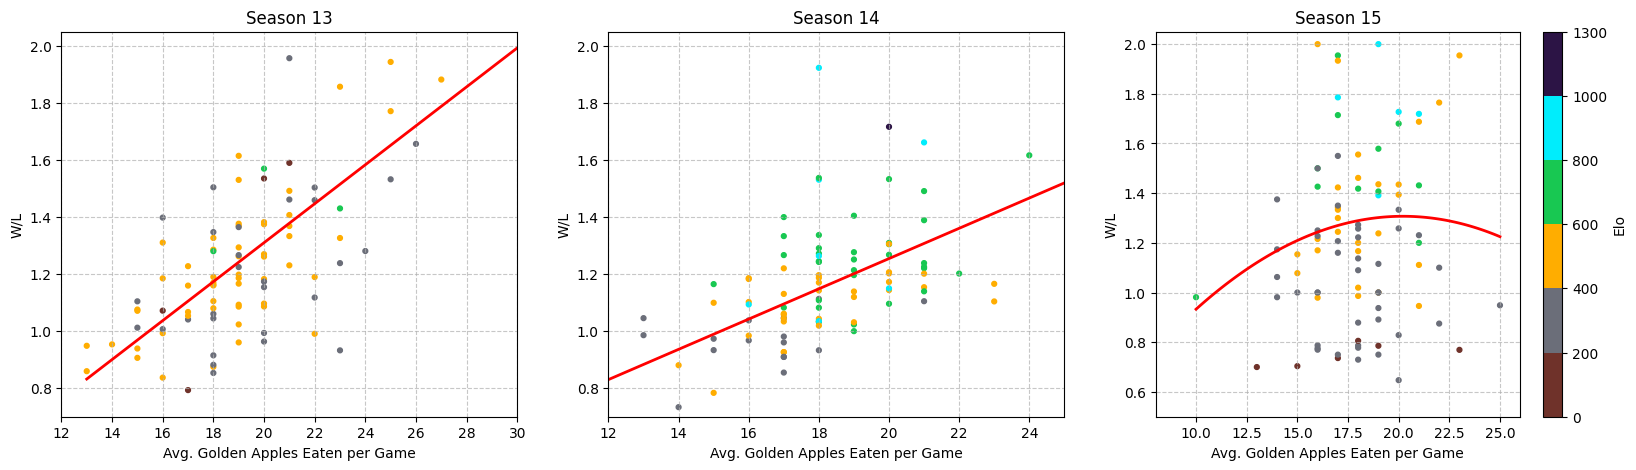

In [202]:
# Replace inf and -inf values with NaN
s13 = s13.replace([np.inf, -np.inf], np.nan)
s13 = s13.dropna()
s14 = s14.replace([np.inf, -np.inf], np.nan)
s14 = s14.dropna()
s15 = s15.replace([np.inf, -np.inf], np.nan)
s15 = s15.dropna()

# Create a new column for average golden apples eaten per game
s13['avg_golden_apples_per_game'] = round(s13['Golden Apples Eaten'] / s13['games'].astype(int))
s14['avg_golden_apples_per_game'] = round(s14['Golden Apples Eaten'] / s14['games'].astype(int))
s15['avg_golden_apples_per_game'] = round(s15['Golden Apples Eaten'] / s15['games'].astype(int))

# Create the figure and axes for the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Scatter plot for s13 dataset
axs[0].scatter(s13['avg_golden_apples_per_game'], s13['w_l'], c=s13['elo'], cmap=cmap, norm=norm, s=12)
axs[0].set_title('Season 13')
axs[0].set_xlabel('Avg. Golden Apples Eaten per Game')
axs[0].set_ylabel('W/L')
axs[0].set_xlim(12, 30)
axs[0].set_ylim(0.7, 2.05)

# Get the x and y values for the trendline
xdata = s13['avg_golden_apples_per_game']
ydata = s13['w_l']

# Fit a polynomial function to the data
coef = np.polyfit(xdata, ydata, 2)

# Get the trendline function
trendline = np.poly1d(coef)

# Plot the trendline
x_vals = np.linspace(min(xdata), max(xdata), 100)
axs[0].plot(x_vals, trendline(x_vals), 'r-', linewidth=2)

# Add gridlines
axs[0].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for s14 dataset
axs[1].scatter(s14['avg_golden_apples_per_game'], s14['w_l'], c=s14['elo'], cmap=cmap, norm=norm, s=12)
axs[1].set_title('Season 14')
axs[1].set_xlabel('Avg. Golden Apples Eaten per Game')
axs[1].set_ylabel('W/L')
axs[1].set_xlim(12, 25)
axs[1].set_ylim(0.7, 2.05)

# Get the x and y values for the trendline
xdata = s14['avg_golden_apples_per_game']
ydata = s14['w_l']

# Fit a polynomial function to the data
coef = np.polyfit(xdata, ydata, 2)

# Get the trendline function
trendline = np.poly1d(coef)

# Plot the trendline
x_vals = np.linspace(min(xdata), max(xdata), 100)
axs[1].plot(x_vals, trendline(x_vals), 'r-', linewidth=2)

# Add gridlines
axs[1].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for s15 dataset
axs[2].scatter(s15['avg_golden_apples_per_game'], s15['w_l'], c=s15['elo'], cmap=cmap, norm=norm, s=12)
axs[2].set_title('Season 15')
axs[2].set_xlabel('Avg. Golden Apples Eaten per Game')
axs[2].set_ylabel('W/L')
axs[2].set_xlim(8, 26)
axs[2].set_ylim(0.5, 2.05)

# Get the x and y values for the trendline
xdata = s15['avg_golden_apples_per_game']
ydata = s15['w_l']

# Fit a polynomial function to the data
coef = np.polyfit(xdata, ydata, 2)

# Get the trendline function
trendline = np.poly1d(coef)

# Plot the trendline
x_vals = np.linspace(min(xdata), max(xdata), 100)
axs[2].plot(x_vals, trendline(x_vals), 'r-', linewidth=2)

# Add gridlines
axs[2].grid(True, linestyle='--', alpha=0.7)

# Show plot
fig.colorbar(sc, ax=axs[2], label="Elo")
plt.show()

## 4.3 Premium Queue
---

In [164]:
def create_prem_df(df, threshold=40):
    df = df[['Player', 'premium_games', 'premium_wins', 'premium_losses']]
    df = df[df.premium_games != 0]
    df = df[df.premium_games > threshold]
    df["w_l"] = df["premium_wins"] / df["premium_losses"]
    return df
#premium_df.sort_values('w_l', ascending=False)

## 4.3.1 Season 13
---

In [165]:
s13_prem = create_prem_df(s13)
dsc_s13 = s13_prem.sort_values('w_l', ascending=False)
asc_s13 = s13_prem.sort_values('w_l', ascending=True)

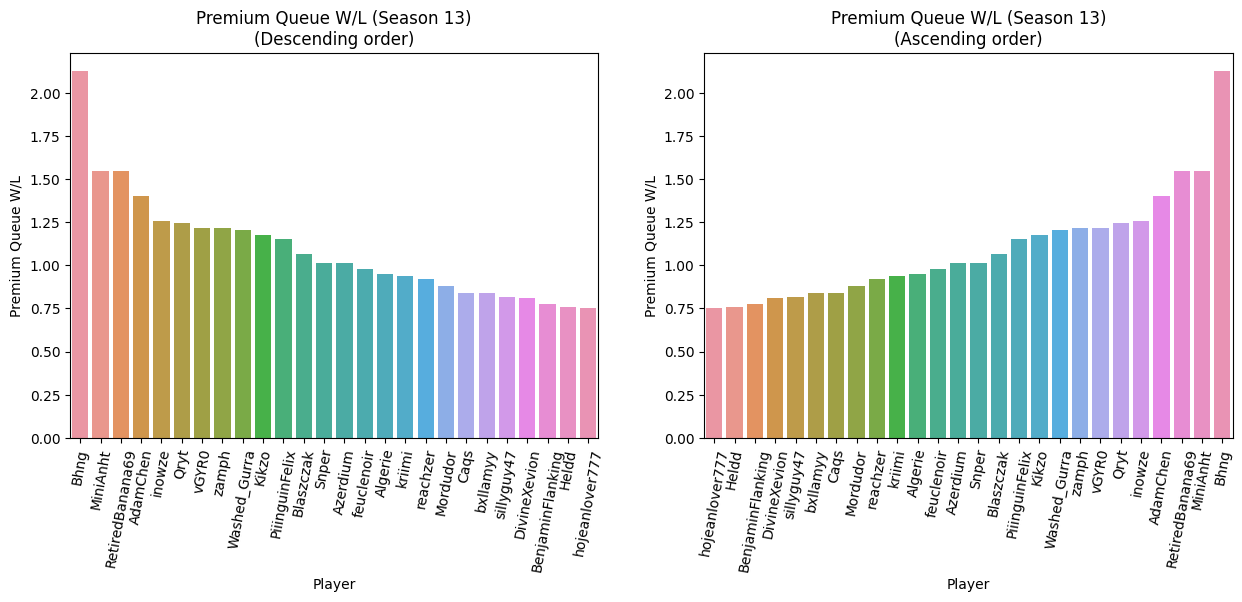

In [167]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the data in the first subplot
sns.barplot(x="Player", y="w_l", data=dsc_s13, ax=axs[0])

# add x and y labels
axs[0].set_xlabel('Player')
axs[0].set_ylabel('Premium Queue W/L')

# add a title
axs[0].set_title('Premium Queue W/L (Season 13)\n(Descending order)')

# rotate x-axis labels by 45 degrees
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=80)

# Plot the data in the second subplot
sns.barplot(x="Player", y="w_l", data=asc_s13, ax=axs[1])

# add x and y labels
axs[1].set_xlabel('Player')
axs[1].set_ylabel('Premium Queue W/L')

# add a title
axs[1].set_title('Premium Queue W/L (Season 13)\n(Ascending order)')

# rotate x-axis labels by 45 degrees
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=80)

# show plot
plt.show()

In [186]:
#dsc_s13

## 4.3.2 Season 14
---

In [184]:
s14_prem = create_prem_df(s14)
dsc_s14 = s14_prem.sort_values('w_l', ascending=False)
asc_s14 = s14_prem.sort_values('w_l', ascending=True)

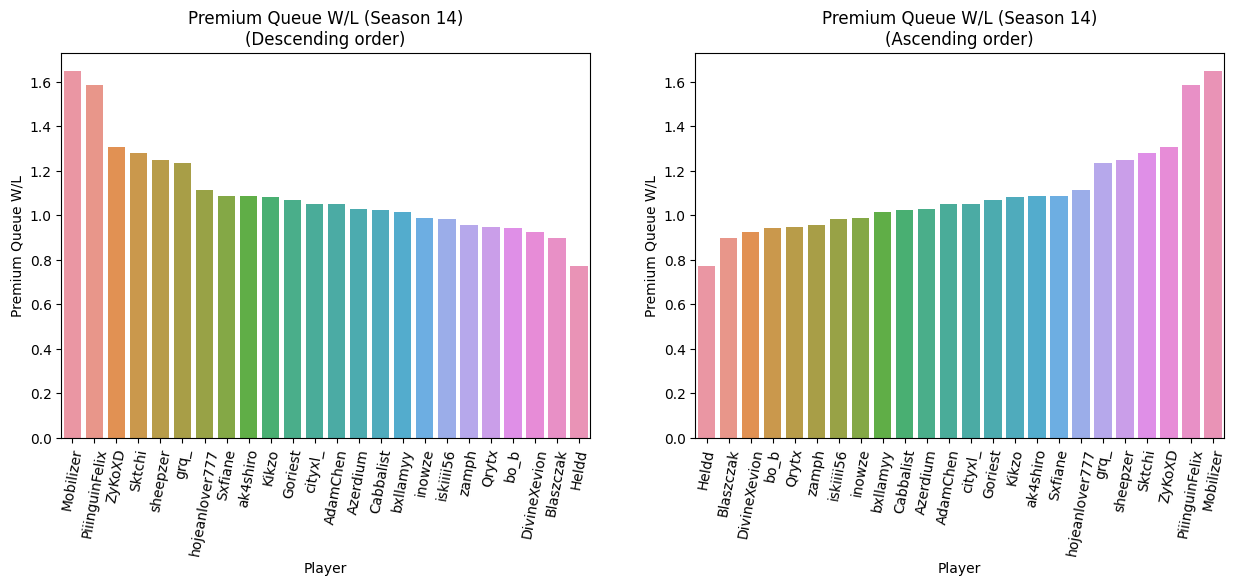

In [185]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the data in the first subplot
sns.barplot(x="Player", y="w_l", data=dsc_s14, ax=axs[0])

# add x and y labels
axs[0].set_xlabel('Player')
axs[0].set_ylabel('Premium Queue W/L')

# add a title
axs[0].set_title('Premium Queue W/L (Season 14)\n(Descending order)')

# rotate x-axis labels by 45 degrees
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=80)

# Plot the data in the second subplot
sns.barplot(x="Player", y="w_l", data=asc_s14, ax=axs[1])

# add x and y labels
axs[1].set_xlabel('Player')
axs[1].set_ylabel('Premium Queue W/L')

# add a title
axs[1].set_title('Premium Queue W/L (Season 14)\n(Ascending order)')

# rotate x-axis labels by 45 degrees
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=80)

# show plot
plt.show()

In [187]:
dsc_s14

,Player,premium_games,premium_wins,premium_losses,w_l
27,Mobilizer,154,94,57,1.649123
34,PiiinguinFelix,164,100,63,1.587302
54,ZyKoXD,287,162,124,1.306452
66,Sktchi,131,73,57,1.280702
9,sheepzer,210,115,92,1.250000
73,grq_,86,47,38,1.236842
25,hojeanlover777,151,78,70,1.114286
56,Sxfiane,166,86,79,1.088608
0,ak4shiro,243,125,115,1.086957
10,Kikzo,234,121,112,1.080357


## 4.3.3 Season 15
---

In [188]:
s15_prem = create_prem_df(s15, 30)
dsc_s15 = s15_prem.sort_values('w_l', ascending=False)
asc_s15 = s15_prem.sort_values('w_l', ascending=True)

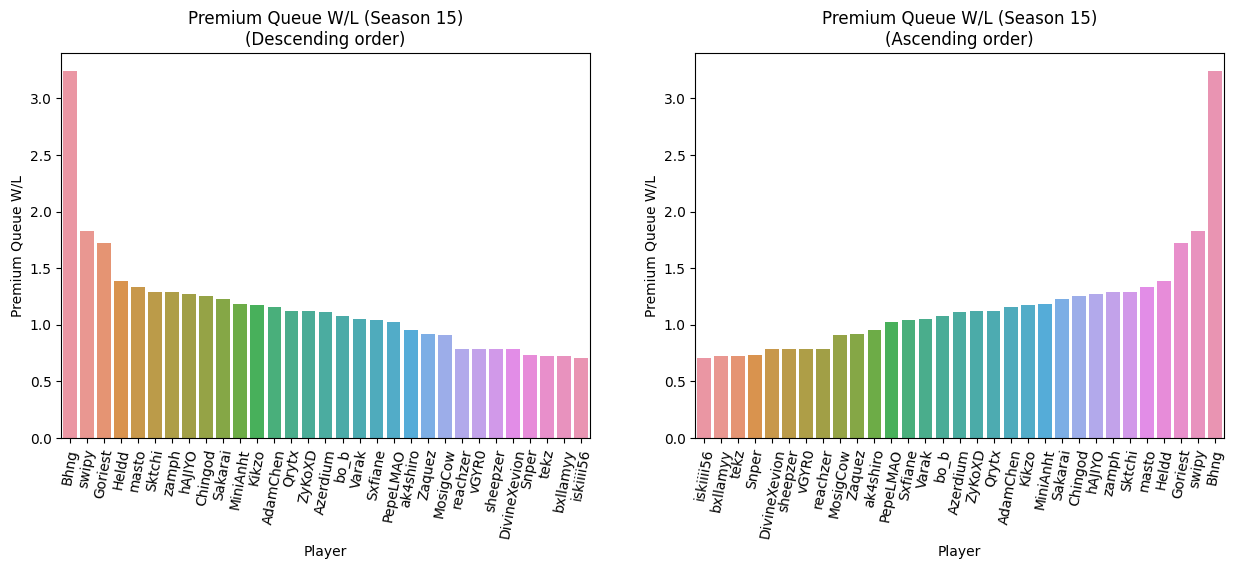

In [189]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the data in the first subplot
sns.barplot(x="Player", y="w_l", data=dsc_s15, ax=axs[0])

# add x and y labels
axs[0].set_xlabel('Player')
axs[0].set_ylabel('Premium Queue W/L')

# add a title
axs[0].set_title('Premium Queue W/L (Season 15)\n(Descending order)')

# rotate x-axis labels by 45 degrees
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=80)

# Plot the data in the second subplot
sns.barplot(x="Player", y="w_l", data=asc_s15, ax=axs[1])

# add x and y labels
axs[1].set_xlabel('Player')
axs[1].set_ylabel('Premium Queue W/L')

# add a title
axs[1].set_title('Premium Queue W/L (Season 15)\n(Ascending order)')

# rotate x-axis labels by 45 degrees
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=80)

# show plot
plt.show()